In [1]:
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
n_epochs = 6
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [5]:
network = Net().cuda()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,momentum=momentum)

In [6]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [22]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    data = data.cuda()
    target = target.cuda()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

In [19]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  
  with torch.no_grad():
    for data, target in test_loader:
      target = target.cuda()
      output = network(data.cuda())
      test_loss += F.nll_loss(output, target, size_average=False).item()
      #print(test_loss)
      pred = output.data.max(1, keepdim=True)[1]
      pred = pred.cuda()
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [20]:
test()

<ipython-input-4-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.2969, Accuracy: 605/10000 (6%)



In [23]:
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

<ipython-input-4-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302672
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.299009
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.266348
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.267941
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.264339
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.206935
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.189606
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.166591
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.147739
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.148651
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.012518
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.938591
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.919257
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.717730
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.700072
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.507264
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.387093
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.316617
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.330607
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.441856
Train Epoch: 1 [12800/60000 (

/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1820, Accuracy: 9472/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.470787
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.456548
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.650587
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.381425
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.497759
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.343995
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.356461
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.424737
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.565559
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.194453
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.614345
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.310699
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.459782
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.421476
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.415532
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.325046
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.410132
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.624518
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.504532
Train Epoch: 2 [12160

Text(0.5, 0, 'number of training examples seen')

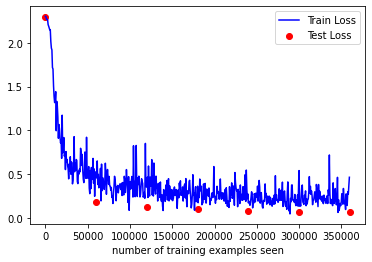

In [24]:
import matplotlib.pyplot as plt

#fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
#plt.ylabel('negative log likelihood loss')

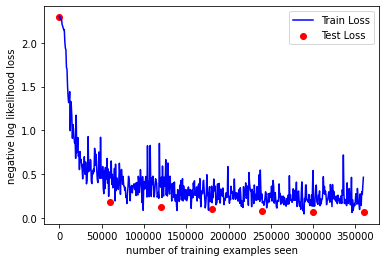

In [31]:
plt.ylabel('negative log likelihood loss')
plt.xlabel('number of training examples seen')
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
